# Logistic Regression and Classification Error Metrics



# Learning Objectives

- Describe Logistic regression and how it differs from linear regression
- Identify metrics for classification errors and scenarios in which they can be used
- Apply Intel® Extension for Scikit-learn* to leverage underlying compute capabilities of hardware

# scikit-learn*

Frameworks provide structure that Data Scientists use to build code. Frameworks are more than just libraries, because in addition to callable code, frameworks influence how code is written.

A main virtue of using an optimized framework is that code runs faster. Code that runs faster is just generally more convenient but when we begin looking at applied data science and AI models, we can see more material benefits. Here you will see how optimization, particularly hyperparameter optimization can benefit more than just speed.

These exercises will demonstrate how to apply **the Intel® Extension for Scikit-learn*,** a seamless way to speed up your Scikit-learn application. The acceleration is achieved through the use of the Intel® oneAPI Data Analytics Library (oneDAL). Patching is the term used to extend scikit-learn with Intel optimizations and makes it a well-suited machine learning framework for dealing with real-life problems.

To get optimized versions of many Scikit-learn algorithms using a patch() approach consisting of adding these lines of code after importing sklearn:

- **from sklearnex import patch_sklearn**
- **patch_sklearn()**

## This exercise relies on installation of  Intel® Extension for Scikit-learn*

If you have not already done so, follow the instructions from Week 1 for instructions

## Introduction

We will be using the [Human Activity Recognition with Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) database, which was built from the recordings of study participants performing activities of daily living (ADL) while carrying a smartphone with an embedded inertial sensors. The objective is to classify activities into one of the six activities (walking, walking upstairs, walking downstairs, sitting, standing, and laying) performed.

For each record in the dataset it is provided:

- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration.
- Triaxial Angular velocity from the gyroscope.
- A 561-feature vector with time and frequency domain variables.
- Its activity label.

More information about the features is available on the website above.

In [ ]:
!pip install scikit-learn-intelex #Only needed for Colab
from __future__ import print_function
import os
data_path = ['data']

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Part 1 - Data Examination and Preprocessing

We start with loading and examining the data, determining the need for scaling (though the data is already scaled between -1 and 1), and encoding categorical labels (activities) as integers for model compatibility.

Import the data and do the following:

* Examine the data types--there are many columns, so it might be wise to use value counts
* Determine if the floating point values need to be scaled
* Determine the breakdown of each activity
* Encode the activity label as an integer

In [ ]:
import pandas as pd
import numpy as np

filepath = os.sep.join(data_path + ['Human_Activity_Recognition_Using_Smartphones_Data.csv'])
data = pd.read_csv(filepath, sep=',')

The data columns are all floats except for the activity label.

In [ ]:
# Count data types across columns, highlighting the numeric nature of most features except the activity label
data.dtypes.value_counts()

float64    561
object       1
dtype: int64

In [ ]:
# Display data types of the last few columns to inspect the activity label type
data.dtypes.tail

<bound method NDFrame.tail of tBodyAcc-mean()-X                       float64
tBodyAcc-mean()-Y                       float64
tBodyAcc-mean()-Z                       float64
tBodyAcc-std()-X                        float64
tBodyAcc-std()-Y                        float64
                                         ...   
angle(tBodyGyroJerkMean,gravityMean)    float64
angle(X,gravityMean)                    float64
angle(Y,gravityMean)                    float64
angle(Z,gravityMean)                    float64
Activity                                 object
Length: 562, dtype: object>

The data are all scaled from -1 (minimum) to 1.0 (maximum).

In [ ]:
# Check the minimum values across features to confirm scaling, ignoring the last column (activity labels)
data.iloc[:, :-1].min().value_counts()

-1.0    561
dtype: int64

In [ ]:
# Check the maximum values across features to confirm scaling, ignoring the last column (activity labels)
data.iloc[:, :-1].max().value_counts()

1.0    561
dtype: int64

Examine the breakdown of activities--they are relatively balanced.

In [ ]:
# Count the number of instances per activity to assess class balance
data.Activity.value_counts()

LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: Activity, dtype: int64

Scikit learn classifiers won't accept a sparse matrix for the prediction column. Thus, either `LabelEncoder` needs to be used to convert the activity labels to integers, or if `DictVectorizer` is used, the resulting matrix must be converted to a non-sparse array.  
Use `LabelEncoder` to fit_transform the "Activity" column, and look at 5 random values.

In [ ]:
# Initialize the LabelEncoder
le = LabelEncoder()
# Transform the 'Activity' column labels to integers
data['Activity'] = le.fit_transform(data.Activity)
# Display a random sample of 5 transformed activity labels to verify encoding
data['Activity'].sample(5)

6368    0
1661    1
7778    4
3244    2
7007    1
Name: Activity, dtype: int64

## Part 2 - Feature Correlation

Understanding correlations between features is crucial as highly correlated features can introduce redundancy and affect model performance. The tutorial involves calculating, visualizing, and analyzing feature correlations to identify significant ones.

* Calculate the correlations between the dependent variables.
* Create a histogram of the correlation values
* Identify those that are most correlated (either positively or negatively).

In [ ]:
# Calculate the correlation values
feature_cols = data.columns[:-1]
corr_values = data[feature_cols].corr()

# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
for coord in zip(*tril_index):
  corr_values.iloc[coord[0], coord[1]] = np.NaN

# Stack the data and convert to a data frame
corr_values = (corr_values
               .stack()
               .to_frame()
               .reset_index()
               .rename(columns= {'level 0':'feature1',
                                 'level_1':'feature2',
                                 0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()


A histogram of the absolute value correlations.

In [ ]:
#import graphing libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

[Text(0.5, 0, 'Absolute Correlation'), Text(0, 0.5, 'Frequency')]

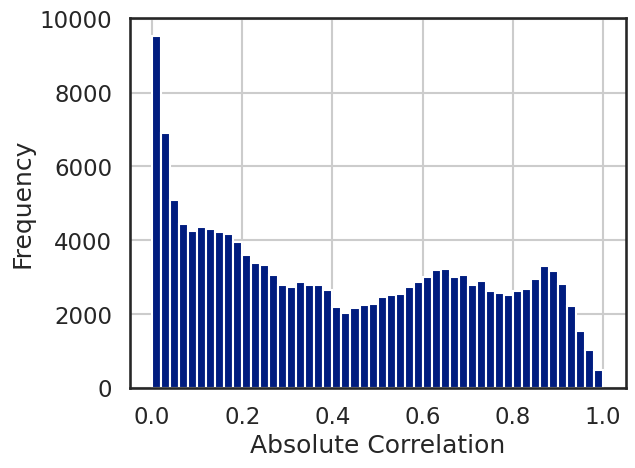

In [ ]:

# Configure Seaborn plot aesthetics for better readability and visual appeal
sns.set_context('talk')  # Set the context to "talk" for larger elements, suitable for presentations
sns.set_style('white')  # Set the background style to "white" for a clean look
sns.set_palette('dark')  # Set the color palette to "dark" for high contrast and visibility of plots

# Plot a histogram of the absolute correlation values to visualize the distribution of feature correlations
ax = corr_values.abs_correlation.hist(bins=50)

# Set the X-axis label to "Absolute Correlation" and Y-axis label to "Frequency" for clarity on plot axes
ax.set(xlabel= 'Absolute Correlation', ylabel= 'Frequency')


In [ ]:
# Filter and sort correlation values to identify highly correlated features
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.8')


,level_0,feature2,correlation,abs_correlation
156894,fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-sma(),1.000000,1.000000
93902,tBodyAccMag-sma(),tGravityAccMag-sma(),1.000000,1.000000
101139,tBodyAccJerkMag-mean(),tBodyAccJerkMag-sma(),1.000000,1.000000
96706,tGravityAccMag-mean(),tGravityAccMag-sma(),1.000000,1.000000
94257,tBodyAccMag-energy(),tGravityAccMag-energy(),1.000000,1.000000
...,...,...,...,...
22657,tGravityAcc-mean()-Y,"angle(Y,gravityMean)",-0.993425,0.993425
39225,"tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4",-0.994267,0.994267
38739,"tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3",-0.994628,0.994628
23176,tGravityAcc-mean()-Z,"angle(Z,gravityMean)",-0.994764,0.994764


In [ ]:
#print(data['Activity'].value_counts())


## Part 3 - Data Splitting

The data is split into training and testing sets to evaluate the model's performance on unseen data. Stratified splitting is used to maintain the proportion of classes across train and test sets.

* Split the data into train and test data sets. This can be done using any method, but consider using Scikit-learn's `StratifiedShuffleSplit` to maintain the same ratio of predictor classes.
* Regardless of methods used to split the data, compare the ratio of classes in both the train and test splits.


In [ ]:
# Use StratifiedShuffleSplit for creating train-test splits while preserving the percentage of samples for each class
strat_shuff_split = StratifiedShuffleSplit(n_splits=1,
                                           test_size=0.3,
                                           random_state=42)

# Generate indices for train and test sets
train_idx, test_idx = next(strat_shuff_split.split(data[feature_cols], data.Activity))

# Create the dataframes
x_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'Activity']

x_test = data.loc[test_idx, feature_cols]
y_test = data.loc[test_idx, 'Activity']


In [ ]:
# Calculate and display the proportion of each class in the training dataset to understand class distribution
y_train.value_counts(normalize=True)


0    0.188792
2    0.185046
1    0.172562
3    0.167152
5    0.149951
4    0.136496
Name: Activity, dtype: float64

## Part 4 - Model Fitting

Logistic Regression models are fitted with different regularization techniques (none, L1, and L2) to prevent overfitting and improve generalization. Regularization adds a penalty on the size of coefficients.

* Fit a logistic regression model without any regularization using all of the features. Be sure to read the documentation about fitting a multi-class model so you understand the coefficient output. Store the model.
* Using cross validation to determine the hyperparameters, fit models using L1, and L2 regularization. Store each of these models as well. Note the limitations on multi-class models, solvers, and regularizations. The regularized models, in particular the L1 model, will probably take a while to fit.

The use of L1 (Lasso) and L2 (Ridge) regularization techniques is used to manage overfitting and underfitting by penalizing large coefficients in the model.

In [ ]:
# Standard logistic regression
lr = LogisticRegression(C=0.001, max_iter=295).fit(x_train, y_train)


In [ ]:
# L1 regularized logistic regression
lr_l1 = LogisticRegressionCV(Cs= 10, cv=4, penalty= 'l1', solver='liblinear').fit(x_train, y_train)

In [ ]:
# L2 regularized logistic regression
lr_l2 = LogisticRegressionCV(Cs=1, cv=4, penalty= 'l2').fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/daal4py/sklearn/linear_model/logistic_path.py:629: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Part 5 - Coefficient Analysis

Analysing the magnitude of coefficients helps understand the influence of each feature on the model's predictions. Regularization can shrink some coefficients, effectively performing feature selection.

Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately.

In [ ]:
# Combine coefficients from all models into a single DataFrame for comparison
coefficients = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab, mod in zip(coeff_labels, coeff_models):
  coeffs = mod.coef_
  coeff_label = pd.MultiIndex(levels=[[lab],[0,1,2,3,4,5]],
                              codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
  coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))
################## End of Loop ######################################

coefficients = pd.concat(coefficients, axis= 1)
coefficients.sample(10)

lr                                                     l1       \
            0         1         2         3         4         5    0    1   
88  -0.010319 -0.014045 -0.018038  0.034344  0.026181 -0.018123  0.0  0.0   
298  0.000251 -0.002385  0.027473 -0.023905 -0.050894  0.049459  0.0  0.0   
404 -0.006761 -0.008920 -0.010727  0.050978 -0.002318 -0.022252  0.0  0.0   
166 -0.011846 -0.023073 -0.014555  0.056563 -0.010326  0.003237  0.0  0.0   
434 -0.011688 -0.011078 -0.021418  0.003951 -0.032247  0.072480  0.0  0.0   
543 -0.007584 -0.014444 -0.010044  0.029698  0.019193 -0.016820  0.0  0.0   
441 -0.006087 -0.007316 -0.010139 -0.007184 -0.005835  0.036562  0.0  0.0   
283 -0.005597 -0.006760 -0.012438 -0.001983  0.003187  0.023591  0.0  0.0   
535 -0.010032 -0.018658 -0.014594  0.009826  0.017342  0.016115  0.0  0.0   
113  0.015771 -0.011947  0.028916 -0.000795  0.006737 -0.038682  0.0  0.0   

                                              l2                      \
       2         3         4         5         0         1         2   
88   0.0  0.000000  0.297244 -0.762452 -0.006383 -0.007100 -0.008011   
298  0.0  0.000000 -1.832815  0.000000 -0.000938  0.002623  0.006223   
404  0.0 -0.413887 -0.360196 -0.165970 -0.004384 -0.004746 -0.005421   
166  0.0  1.513043 -1.725025  0.965609 -0.007350 -0.008967 -0.008206   
434  0.0  0.000000 -0.227741  1.839415 -0.006616 -0.006616 -0.008381   
543  0.0  0.192894  0.000000 -0.241638 -0.005342 -0.006605 -0.006242   
441  0.0  0.014268 -0.011559  0.000000 -0.003683 -0.003870 -0.004592   
283  0.0 -0.073230 -0.031046  0.000000 -0.004280 -0.004471 -0.005657   
535  0.0 -0.723046  0.058420  0.000000 -0.006806 -0.008307 -0.007944   
113  0.0  0.000000  0.000000 -1.239633  0.007779  0.002936  0.006339   

                                   
            3         4         5  
88   0.011269  0.010839 -0.000615  
298 -0.008135 -0.010782  0.011009  
404  0.015451  0.005025 -0.005926  
166  0.016201  0.006426  0.001896  
434  0.004128 -0.001891  0.019376  
543  0.011204  0.009245 -0.002257  
441 -0.000059  0.001836  0.010367  
283  0.000921  0.003808  0.009679  
535  0.007258  0.009292  0.006507  
113 -0.003407  0.000052 -0.013699

Prepare six separate plots for each of the multi-class coefficients.

### What Does Comparing Coefficients Mean?
* Feature Importance: The magnitude of a coefficient corresponds to the feature's importance for that class in the OvR scheme. A larger absolute value indicates a stronger influence on the model's decision boundary. Positive coefficients increase the log-odds of the class, suggesting that higher values of the associated feature make the class more likely. Conversely, negative coefficients decrease the log-odds, making the class less likely as the feature value increases.

* Model Differences: By comparing coefficients across different models (e.g., standard logistic regression, L1-regularized, and L2-regularized models), you can see how regularization affects feature importance. L1 regularization can shrink some coefficients to zero, effectively performing feature selection by eliminating certain features. L2 regularization tends to shrink coefficients more uniformly but does not set them to zero.

* Inter-class Differences: Within the OvR framework, comparing coefficients for the same feature across different classes can reveal how that feature influences the distinction between each class and the rest. A feature might be highly positive for one class, slightly positive or even negative for another, highlighting the feature's varying role in distinguishing between classes.

### How to Plot and Interpret the Coefficients
Separate Plots for Each Class: Since each class in an OvR logistic regression model has its own set of coefficients, you might create separate plots for each class to clearly visualize how features influence the probability of each specific class. This approach helps in understanding the model's behavior on a class-by-class basis.

* Magnitude and Direction: In your plots, the X-axis could represent the features, and the Y-axis could represent the coefficient values. Bars extending upwards indicate a positive influence on the class probability, while bars extending downwards indicate a negative influence.

* Comparative Analysis: When plotting coefficients for different models (standard, L1, L2) side by side for each class, you can visually compare how regularization affects the magnitude and even the selection of features. This comparison can be crucial for understanding the trade-offs between model complexity, feature selection, and model interpretability.

* In summary, comparing the magnitudes of coefficients across different models and classes helps in interpreting the role of features in classification, understanding the impact of regularization, and identifying which features are consistently important across classes and which ones have class-specific roles. This analysis is a key part of model interpretation, helping to validate the model's decisions and potentially offering insights into the underlying data structure and relationships.

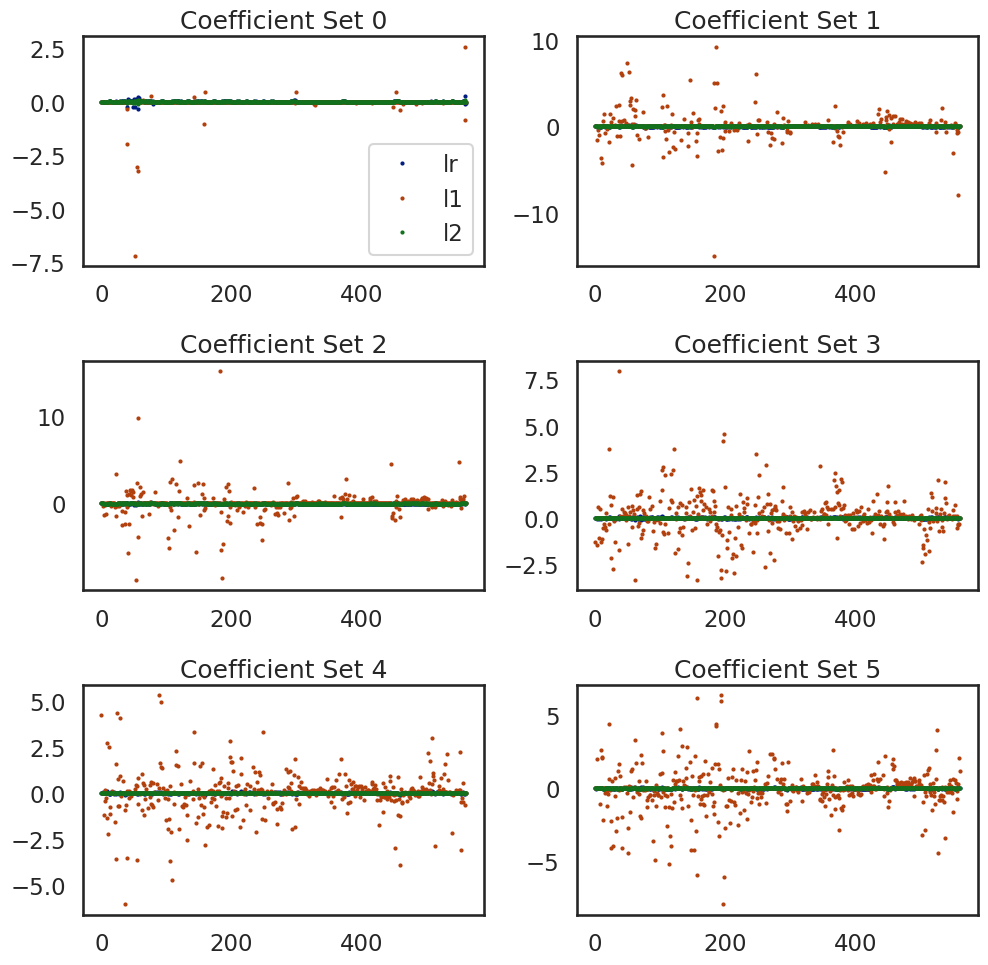

In [ ]:
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)

for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]

    data = coefficients.xs(loc, level=1, axis=1)
    data.plot(marker='o', ls='', ms=2.0, ax=ax, legend=False)

    if ax is axList[0]:
        ax.legend(loc=4)

    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()

## Question 6 - Prediction and Probability Estimation

The models are used to predict activity classes and estimate the probabilities of these predictions. This step is crucial for evaluating the model's confidence in its predictions.

* Predict and store the class for each model.
* Also store the probability for the predicted class for each model.

In [ ]:
# Predict class labels and the associated probabilities for the test set using each model
y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab, mod in zip(coeff_labels, coeff_models):
  y_pred.append(pd.Series(mod.predict(x_test), name=lab))
  y_prob.append(pd.Series(mod.predict_proba(x_test).max(axis=1), name=lab))
################## End of Loop ######################################

y_pred = pd.concat(y_pred, axis= 1)
y_prob = pd.concat(y_prob, axis= 1)

y_pred.head()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


,lr,l1,l2
0,3,3,3
1,5,5,5
2,3,3,3
3,1,1,1
4,0,0,0


In [ ]:
# Display the first five rows of the predicted class probabilities for each model to examine model confidence in predictions
y_prob.head()

,lr,l1,l2
0,0.732966,0.998936,0.344193
1,0.510253,0.999498,0.313597
2,0.561494,0.995465,0.305890
3,0.537572,0.999149,0.333241
4,0.822260,0.999921,0.486692


## Part 7 - Error Metric Calculation

Various error metrics are calculated for each model to assess their performance comprehensively. This includes combining multi-class metrics into a single value to simplify evaluation.

For each model, calculate the following error metrics:

* accuracy
* precision
* recall
* fscore
* confusion matrix

Decide how to combine the multi-class metrics into a single value for each model.

In [ ]:
# Initialize an empty list for storing model evaluation metrics and a dictionary for confusion matrices
metrics = list()
cm = dict()

# Loop through each label of the fitted models to calculate and store evaluation metrics
for lab in coeff_labels:
    # Calculate precision, recall, and F-score using a weighted average to account for class imbalance
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average= 'weighted')

    # Calculate the overall accuracy of the model as the proportion of correct predictions
    accuracy = accuracy_score(y_test, y_pred[lab])

    # Calculate the weighted average ROC-AUC score by first binarizing the output
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2,3,4,5]),
                        label_binarize(y_pred[lab], classes=[0,1,2,3,4,5]),
                        average = 'weighted')

    # Generate the confusion matrix for the model, showing the distribution of predicted vs. actual class labels
    cm[lab] = confusion_matrix(y_test, y_pred[lab])

    # Store the calculated metrics for each model in the metrics list as a pandas Series
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 'fscore':fscore, 'accuracy':accuracy, 'auc':auc}, name=lab))

# Concatenate all metrics into a single DataFrame for easier comparison across models
metrics = pd.concat(metrics, axis=1)


In [ ]:
metrics

,lr,l1,l2
precision,0.911431,0.984153,0.866900
recall,0.910680,0.984142,0.852427
fscore,0.910151,0.984140,0.845593
accuracy,0.910680,0.984142,0.852427
auc,0.946078,0.990342,0.910622


* Precision: Precision measures the accuracy of the positive predictions made by the model. In other words, it is the ratio of true positive predictions to the total number of positive predictions (true positives + false positives). A precision of 0.911431 suggests that when the model predicts a class positively, it is correct about 91.14% of the time. Precision is particularly important in scenarios where the cost of false positives is high.

* Recall: Recall, also known as sensitivity or true positive rate, measures the ability of the model to correctly identify all actual positives. It is calculated as the ratio of true positives to the actual positives (true positives + false negatives). A recall of 0.910680 indicates that the model correctly identifies 91.07% of all actual positive instances. Recall is crucial in situations where missing a positive instance (false negative) is costly.

* F-Score (0.910151): The F-score, specifically the F1-score in most contexts, is the harmonic mean of precision and recall. It provides a single metric that balances both precision and recall, useful when you want to consider both false positives and false negatives in your model evaluation. An F-score of 0.910151 suggests a good balance between precision and recall, indicating that the model is robust in terms of both avoiding false positives and identifying true positives.

* Accuracy: Accuracy measures the overall correctness of the model across all classes, calculated as the ratio of correct predictions (true positives + true negatives) to the total number of instances. An accuracy of 0.910680 means that the model correctly predicts the class (whether positive or negative) for 91.07% of all instances. While accuracy is a straightforward and intuitive metric, it can be misleading for imbalanced datasets where one class dominates.

* AUC: The Area Under the ROC Curve (AUC) measures the ability of the model to distinguish between classes. The ROC curve plots the true positive rate (recall) against the false positive rate at various threshold settings. An AUC of 0.946078 is quite high, indicating that the model has a strong capability to differentiate between the classes, with a high likelihood of ranking a randomly chosen positive instance higher than a randomly chosen negative one.

Each of these metrics provides valuable insights into different aspects of the model's performance, helping to understand its strengths and weaknesses in the context of the specific problem it's being used to solve.

## Part 8 - Confusion Matrix Visualization

The confusion matrices for each model are visualized to provide insights into the specific areas where each model performs well or poorly, indicating potential areas for improvement.

Display or plot the confusion matrix for each model.

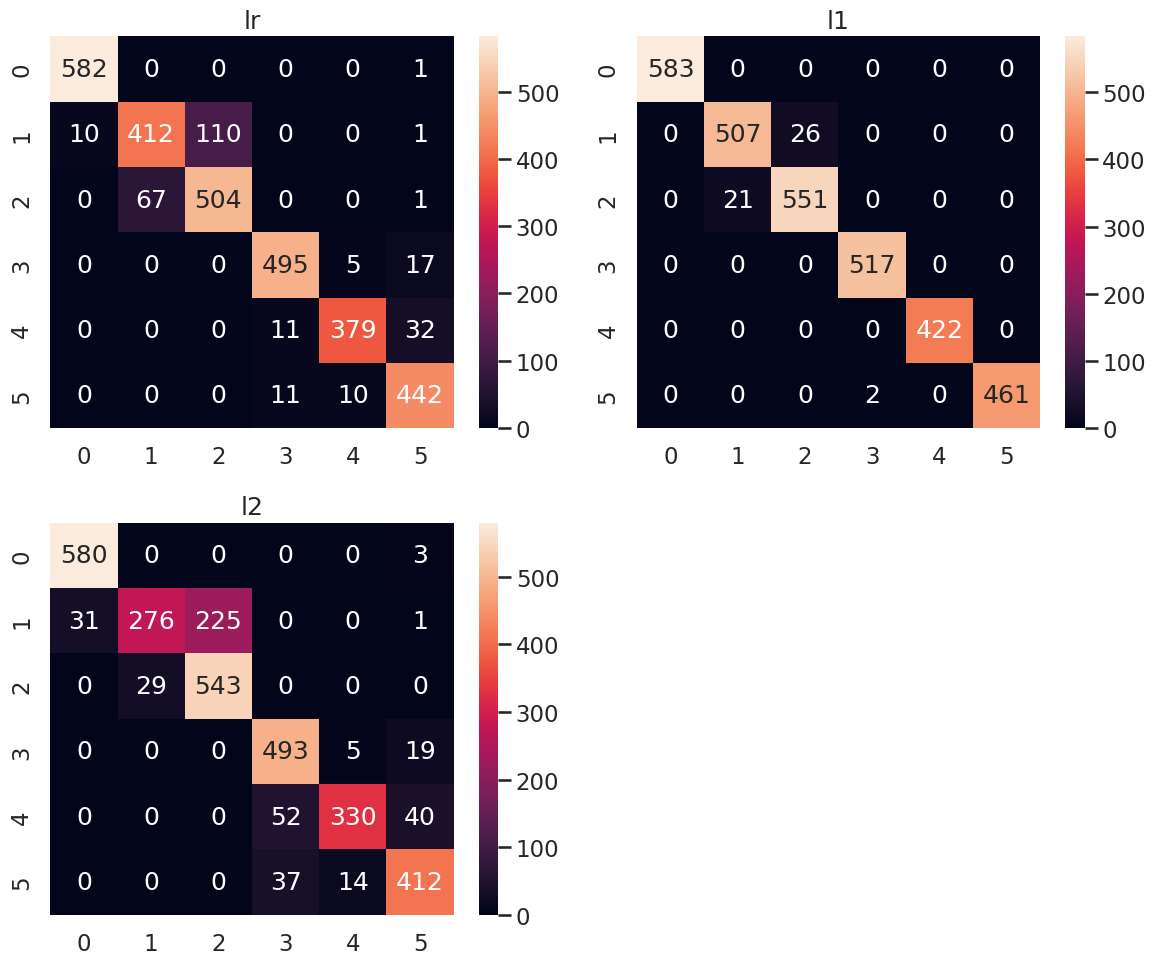

In [ ]:
#Plot a confusion matrix for each model to help visualise accuracy
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12,10)

axList[-1].axis('off')

for ax, lab in zip(axList[:-1], coeff_labels):
  sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d')
  ax.set(title=lab)

plt.tight_layout()


### Analysis of these results
* High Diagonal Values: The diagonal cells in a confusion matrix represent the number of true positives for each class, meaning these are the instances where the model's predictions matched the actual class labels correctly. High values along the diagonal are a good sign, indicating that the model is correctly identifying a significant number of instances for each class.

* Low Off-Diagonal Values: The off-diagonal cells show the number of misclassifications, where the model predicted a class different from the actual class. Low values in these cells suggest that there are few misclassifications between classes, indicating that the model is not often confused between different classes.

* Model Accuracy: The prominence of the diagonal, combined with the low values in the off-diagonal cells, suggests that your model has a high accuracy rate. Most of the predictions are correct, with only a small fraction of instances being misclassified.